$$\renewcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\renewcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$\renewcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$

In [1]:
# Uncomment the following line to install the required packages if not already installed
# !pip install qiskit qiskit-aer qiskit-ibm-runtime matplotlib pylatexenc qiskit-ibm-transpiler[ai-local-mode] mthree

# Quantum Walks and Monte Carlo

## Part I - Universal Statistical Simulator - Approach Summary

The 2-pager description of the approach to achieve various distributions with Quantum Galton Board can be found here: [solution summary](solution_2pager.pdf).

## Part II - General Algorithm for Quantum Galton Box

In this part, we are generalizing the Quantum Galton Board approach to $n$ levels. We put the circuit code as well as simulation runs in this notebook while two helper modules we created are outside of this notebook not to clutter the code (`circuit_runner.py` and `distributions.py`). These helper module encapsulate:
- Circuit running
- Plotting sampled distributions against reference ones
- Generating distributions (normal, exponential, hadamard walk) that are used as references to compare to

Below we import the required SDK modules as well helpers that we created.

In [2]:
from typing import List, Tuple

import math
import numpy as np
from collections import defaultdict

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile

import matplotlib.pyplot as plt

from circuit_runner import RunMode, run_simulation, ai_transpile_circuit
from distributions import DistributionGenerator, DistributionType

In [3]:
plt.style.use("dark_background")

Set the global parameters:
- `SHOTS` - how many shots to sample when running quantum circuit
- `ENABLE_REAL_DEVICE` - controls whether to submit the jobs to a real backend

The `results` dictionary will collect the outcomes of various runs for later analysis.

In [4]:
SHOTS = 2048
ENABLE_REAL_DEVICE = False
results = {}

`create_qdb_circuit` builds the Quantum Galton Board given the number of levels `n` and a `coin` function.

In [5]:
def calculate_wire_tuples(n, level) -> List[Tuple[int, int]]:
    if level < 1 or level > n:
        raise ValueError("Level must be between 1 and n (inclusive).")
    middle = n + 1
    start, finish = middle - level, middle + level
    return [(i, i + 1) for i in range(start, finish)]

def create_qgb_circuit(n, coin) -> QuantumCircuit:
    """Creates a quantum circuit for the Quantum Galton Board (QGB) with n levels."""

    def qpegs(qc: QuantumCircuit, wire_tuples: List[Tuple[int]]):
        """Apply the quantum pegs operation for the Galton Board."""
        for i, wires in enumerate(wire_tuples):
            qc.cswap(0, wires[0], wires[1])
            if i < len(wire_tuples) - 1:
                qc.cx(wires[1], 0)


    def levels(qc: QuantumCircuit):
        """Apply the quantum pegs for each level of the Galton Board."""
        qc.x(n + 1)
        for level in range(1, n + 1):
            coin(qc, n, level)
            qpegs(qc, calculate_wire_tuples(n, level))
            if level < n:
                qc.reset(0)
            qc.barrier()

    def measures(qc: QuantumCircuit):
        """Final measurement of tally qubits"""
        for cbit, qbit in enumerate(range(1, 2 * n + 2, 2)):
            qc.measure(qbit, cbit)

    quantum_coin = QuantumRegister(1, "coin")
    qgb = QuantumRegister(2 * n + 1, "QGB")
    distribution = ClassicalRegister(n + 1, "distribution")
    circuit = QuantumCircuit(
        quantum_coin, qgb, distribution, name="Quantum Galton Board"
    )
    levels(circuit)
    measures(circuit)
    return circuit

In [6]:
def hadamard_coin(qc: QuantumCircuit, n: int, level: int):
    """Applies a Hadamard coin operation for the Quantum Galton Board."""
    qc.h(0)

Below we show the 3 levels circuit for quantum galton board.

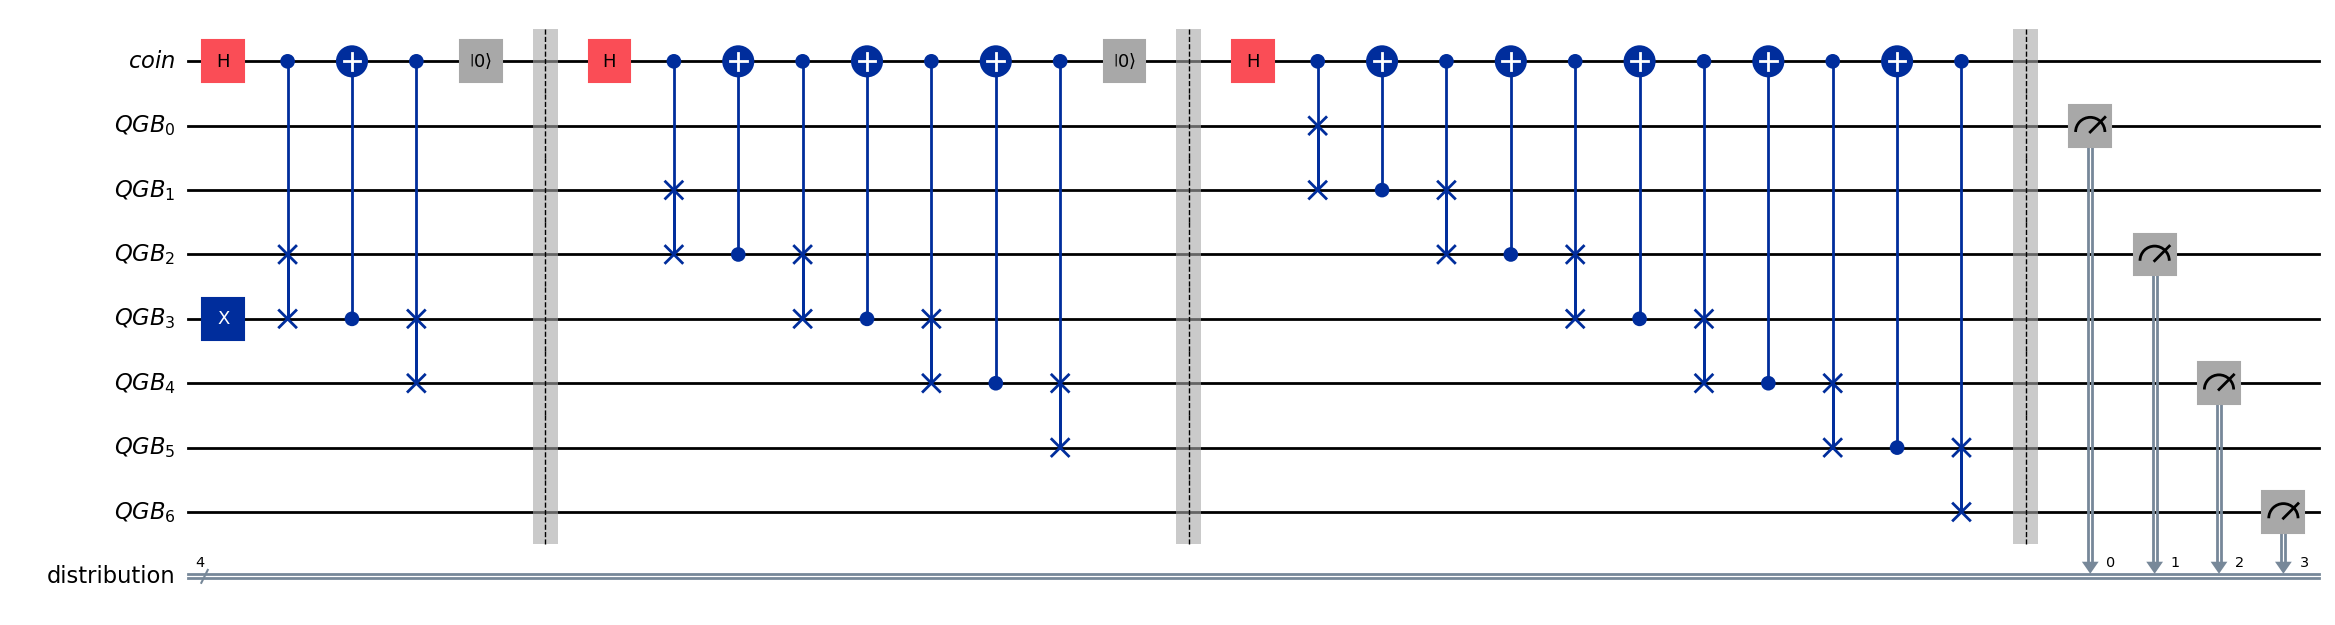

In [7]:
qc = create_qgb_circuit(3, hadamard_coin)
qc.draw("mpl", fold=-1)

In the `circuit_runner.py` helper module, we defined a function that will run the appropriate simulation of our circuit. It will leverage CircuitRunner class to execute the circuits, get the results and plot them against the reference distribution. `DistributionGenerator` class is used to calculate the perfect case of reference distributions. It supports normal, exponential, hadamard random walk and uniform distribution generation.

Width and depth of transpiled circuit: 21, 90


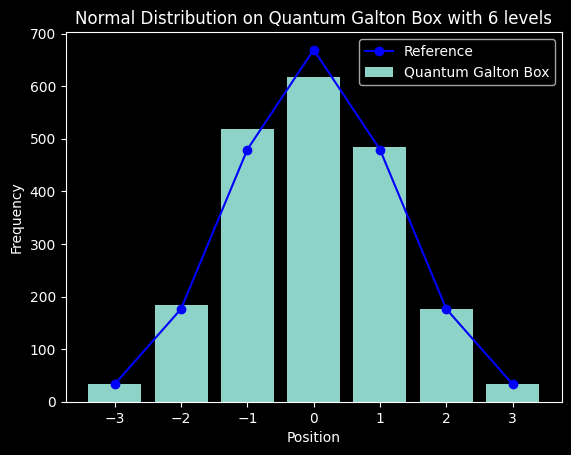

In [8]:
n = 6
results["gaussian_noiseless"] = run_simulation(
    n,
    SHOTS,
    create_qgb_circuit,
    hadamard_coin,
    RunMode.NOISELESS_SIMULATOR,
    DistributionType.NORMAL,
    f"Normal Distribution on Quantum Galton Box with {n} levels",
)

We can see that noiseless simulation has a good match with the reference distribution.

Our implementation is fairly generic and allows easy introduction of custom coins that control the distribution. As an example, we could have a biased distribution with RY-rotation coin as demonstrated below.

Width and depth of transpiled circuit: 21, 90


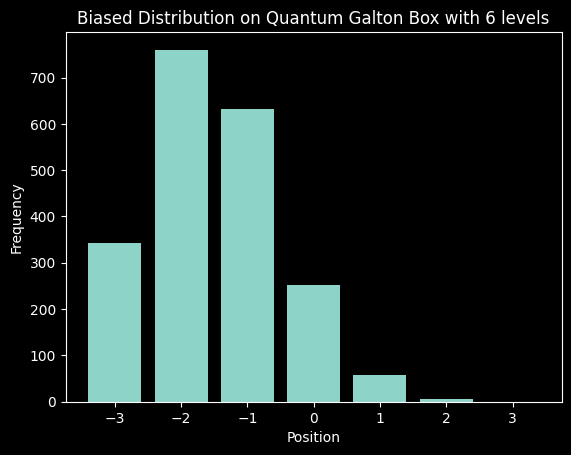

In [9]:
coin_function = lambda qc, n, level: qc.ry(2 * np.pi / 3, 0)
n = 6
_ = run_simulation(
    n,
    SHOTS,
    create_qgb_circuit,
    coin_function,
    RunMode.NOISELESS_SIMULATOR,
    title=f"Biased Distribution on Quantum Galton Box with {n} levels",
    show_reference=False,
)

## Part III - Modified Target Distributions

As mentioned in Part II, we are able to introduce different coins in order to modify the output distribution of our Quantum Galton Box. In this part, we will generate Exponential Distribution and Hadamard Quantum Walk.

### Exponential Distribution

Let's now create an exponential coin that modifies the righmost peg on each level. We will condition its rotation on the appropriate qubit for each level.

In [10]:
def exponential_coin(qc: QuantumCircuit, n, level):
    """Applies an exponential coin rotation based on the level."""
    theta = 2 * math.acos(np.sqrt(1 / np.e))
    if level == 1:
        qc.ry(theta, 0)
    else:
        middle = n + 1
        for i in range(middle - level + 1, middle + level - 1):
            qc.cx(i, 0)
        qc.cry(theta, middle + level - 1, 0)

Width and depth of transpiled circuit: 21, 120


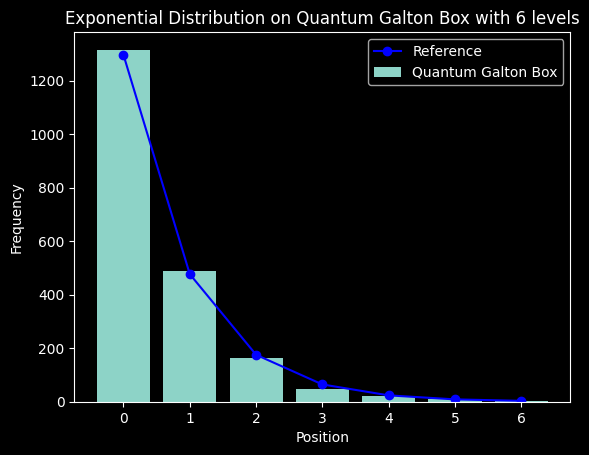

In [11]:
n = 6
results["exponential_noiseless"] = run_simulation(
    n,
    SHOTS,
    create_qgb_circuit,
    exponential_coin,
    RunMode.NOISELESS_SIMULATOR,
    distribution_type=DistributionType.EXPONENTIAL,
    title=f"Exponential Distribution on Quantum Galton Box with {n} levels",
)

### Hadamard Quantum Walk

We modify the QGB circuit to simultaneously shift the ball left and right (controlled by the coin state). It removes the need to apply CNOT between the controlled-SWAP operations, but we now have to control it both on 0 and 1 values of the coin.

In [12]:
def calculate_hrw_wire_tuples(n, level) -> List[Tuple[int, int]]:
    if level < 1 or level > n:
        raise ValueError("Level must be between 1 and n (inclusive).")
    middle = n + 1
    return [(i, i + 1) for i in range(middle - level, middle + level)]


def calculate_hrw_fs_wire_tuples(n) -> List[Tuple[int, int]]:
    iterations = math.floor((n + 1) / 2)
    return [(i * 2 + 1, 2 * n + 2 - (i * 2) - 1) for i in range(iterations)]


def create_hrw_qgb_circuit(n, coin) -> QuantumCircuit:
    """Creates a quantum circuit for the n-steps Hadamard Walk distribution
    leveraging the Quantum Galton Board (QGB) with n levels."""

    def qpegs(qc: QuantumCircuit, wire_tuples):
        control_value = 0
        for wires in wire_tuples:
            qc.cswap(0, wires[0], wires[1], ctrl_state=control_value)
            control_value ^= 1

    def levels(qc: QuantumCircuit):
        qc.x(n + 1)
        for level in range(1, n + 1):
            coin(qc, n, level)
            qpegs(qc, calculate_hrw_wire_tuples(n, level))
            qc.barrier()

    def final_swap(qc: QuantumCircuit):
        qc.reset(0)
        qc.h(0)
        for wires in calculate_hrw_fs_wire_tuples(n):
            qc.cswap(0, wires[0], wires[1])
        qc.barrier()

    def measures(qc: QuantumCircuit):
        for cbit, qbit in enumerate(range(1, 2 * n + 2, 2)):
            qc.measure(qbit, cbit)

    qr = QuantumRegister(2 * n + 2)
    distribution = ClassicalRegister(n + 1, "distribution")
    circuit = QuantumCircuit(qr, distribution)
    levels(circuit)
    final_swap(circuit)
    measures(circuit)
    return circuit

Notice that the Hadamard circuit doesn't reset the coin qubit after each level to keep the interference going. We do reset it after the last level to apply the swap with probability 0.5 in order to obtain symmetric distribution of Hadamard Random Walk. See circuit drawing below.

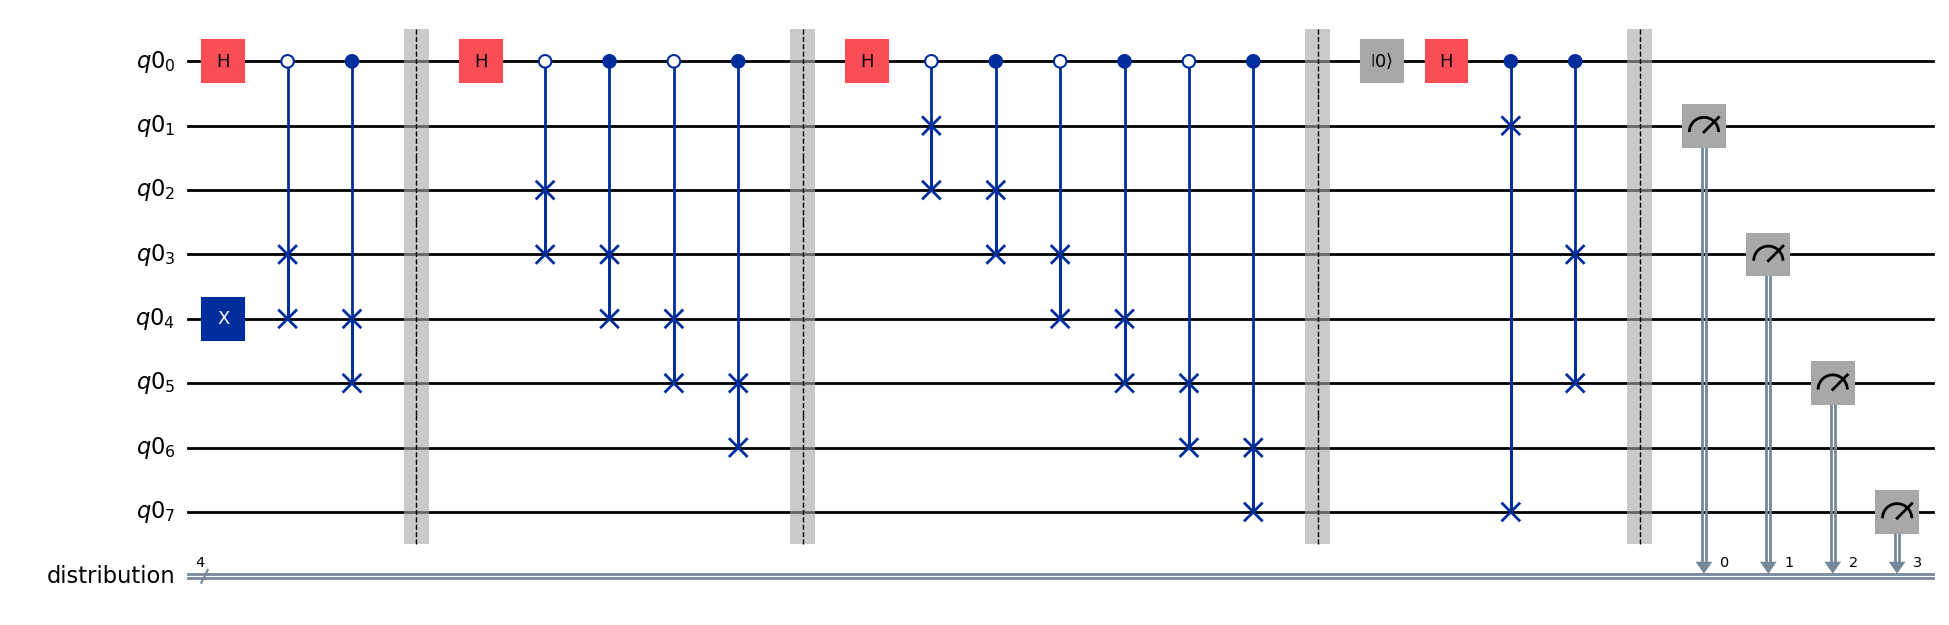

In [13]:
circuit = create_hrw_qgb_circuit(3, hadamard_coin)
circuit.draw("mpl", fold=-1)

Width and depth of transpiled circuit: 21, 90


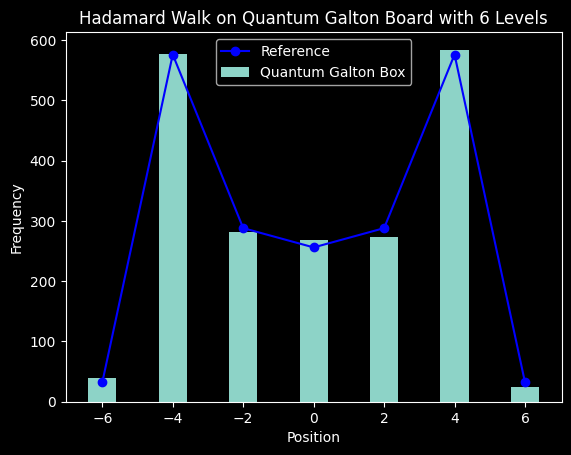

In [14]:
n = 6
results["hadamard_noiseless"] = run_simulation(
    n,
    SHOTS,
    create_hrw_qgb_circuit,
    hadamard_coin,
    RunMode.NOISELESS_SIMULATOR,
    distribution_type=DistributionType.HADAMARD,
    title=f"Hadamard Walk on Quantum Galton Board with {n} Levels",
)

## Part IV - Optimization under Noise Models

Having our implementation working on the noiseless simulators, we will now work on exploring the circuit under a noise model.

In [15]:
service = QiskitRuntimeService()
real_torino = service.backend("ibm_torino")
real_brisbane = service.backend("ibm_brisbane")
least_busy_backend = service.least_busy()
print(f"torino qubits: {real_torino.num_qubits}, brisbane qubits: {real_brisbane.num_qubits}")
print(f"least busy backend: {least_busy_backend.name}, qubits: {least_busy_backend.num_qubits}")

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-08-03 23:54:43,893: Default instance not set. Searching all available instances.


torino qubits: 133, brisbane qubits: 127
least busy backend: ibm_torino, qubits: 133


After careful observations of the Galton board properties, it is possible to create a universal distribution simulator and optimize the use of qubits. The naive implementation requires $2n+2$ qubits. We can load any distribution using only $n+3$ qubits. It is worth noting that Galton board produced a superposition of all states with Hamming Weight 1 (single qubit is 1 and the rest are 0). For example, in case of 2 levels Galton board, we have 3 tally bin qubits and the resulting state will be $\alpha\ket{001} + \beta\ket{010} + \gamma\ket{100}$ (or $\alpha\ket{1}_3 + \beta\ket{2}_3 + \gamma\ket{4}_3$ in a more compact notation) for some arbitrary distribution. In a more general case, we can write it as:

$\ket{\psi} = \sum_{i=0}^{n}{\sqrt{p(i)}\ket{2^i}}_{n+1}$

$\sum_{i=0}^{n}{p(i)} = 1$

$\forall i\:\:p(i) >= 0$

Given the vector of $n+1$ probabilities, we can build an optimized coin function and a quantum circuit to assure the ball reaches each tally bin with the desired probability (implementation below).

The calculation of rotation angle for level $i$ is as follows:

$\theta_i = 2arccos(\sqrt{1-\frac{p_i}{\sum_{j=i}^{n}{p_j}}})$


In [16]:
def optimized_coin(qc: QuantumCircuit, n, level, probs: np.ndarray):
    """Applies the required coin rotation based on the level."""
    if level == 1:
        prob = probs[0]
        theta = 2 * math.acos(np.sqrt(1-prob))
        qc.ry(theta, 0)
    else:
        prob = probs[level - 1] / probs[(level-1):].sum()
        theta = 2 * math.acos(np.sqrt(1-prob))
        qc.cry(theta, level + 1, 0)

def calculate_opt_wire_tuples(n, level) -> List[Tuple[int, int]]:
    if level < 1 or level > n:
        raise ValueError("Level must be between 1 and n (inclusive).")
    return [(i, i + 1) for i in range(level, level + 2)]


def create_opt_qgb_circuit(n, coin, probs: list | np.ndarray) -> QuantumCircuit:
    """Creates an optimized quantum circuit for the Quantum Galton Board (QGB) with n levels."""

    if isinstance(probs, list):
        my_probs  = np.array(probs)
    else:
        my_probs = probs
    def qpegs(qc: QuantumCircuit, wire_tuples: List[Tuple[int]]):
        for i, wires in enumerate(wire_tuples):
            qc.cswap(0, wires[0], wires[1])
            if i < len(wire_tuples) - 1:
                qc.cx(wires[1], 0)

    def levels(qc: QuantumCircuit):
        qc.x(2)
        for level in range(1, n + 1):
            coin(qc, n, level, my_probs)
            qpegs(qc, wire_tuples=calculate_opt_wire_tuples(n, level))
            if level < n:
                qc.reset(0)
            qc.barrier()

    def measures(qc: QuantumCircuit):
        for cbit, qbit in enumerate(list(range(1, n + 1)) + [n + 2]):
            qc.measure(qbit, cbit)

    qr = QuantumRegister(n + 3)
    distribution = ClassicalRegister(n + 1, "distribution")
    circuit = QuantumCircuit(qr, distribution)
    levels(circuit)
    measures(circuit)
    return circuit

The circuit is now more compact and the number of required CSWAP gates is significantly reduced. Let's draw the 4-level circuit with some arbitrary probability distribution vector.

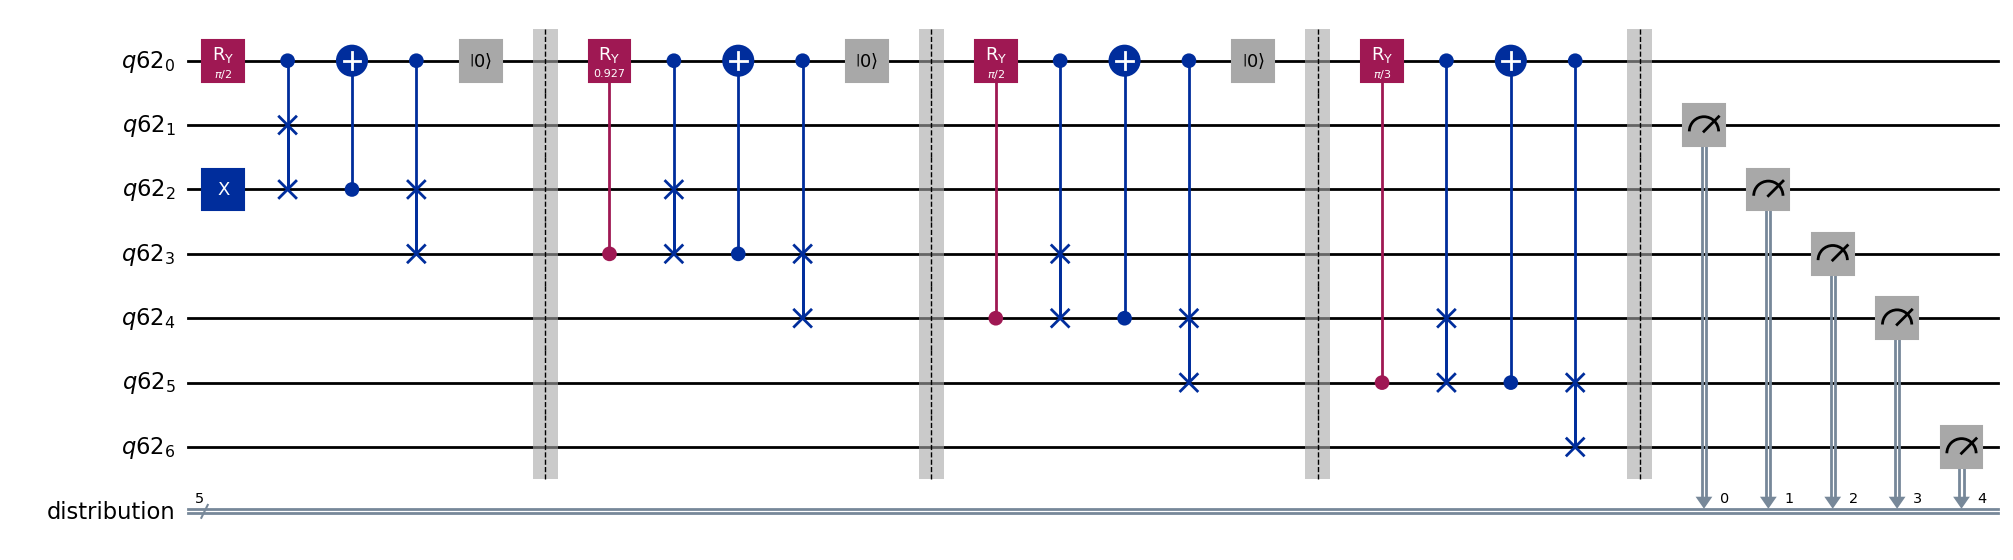

In [31]:
circuit = create_opt_qgb_circuit(4, optimized_coin, [0.5, 0.1, 0.2, 0.05, 0.15])
circuit.draw("mpl", fold=-1)

Let's now apply the optimized circuit approach to the three distributions we are studying: Gaussian, Exponential and Hadamard Random Walk.

We will run all the distribution generations under the following three simulations:
- Noiseless AER simulator
- Noisy Simulator with noise model from the `ibm_torino` QPU backend
- Real device (IBM Torino)

We set the $n$ levels for all noisy simulations to be equal to check how each distribution holds under the same conditions.

In [17]:
n = 10
dg = DistributionGenerator(n, SHOTS)

### Gaussian Distribution

Below, we generate the Gaussian probabilities and execute the simulations storing the result for further comparison.


Width and depth of transpiled circuit: 24, 50


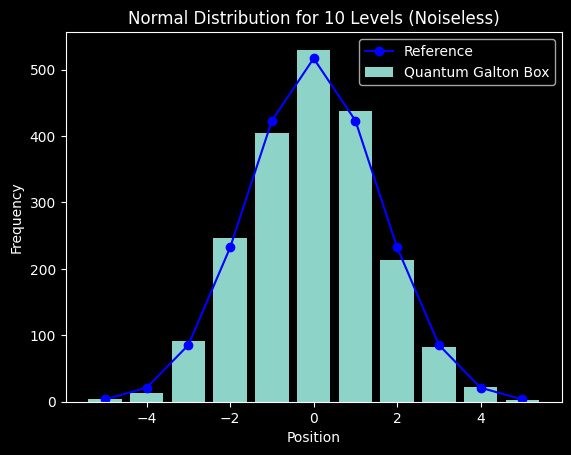

Width and depth of transpiled circuit: 144, 1171
Width and depth after AI Pass: 144, 874


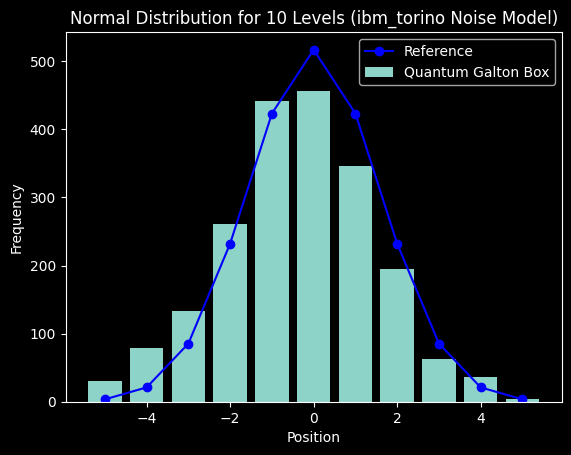

In [18]:
gaussian = dg.normal(generate_probs=True)[1]
results["gaussian_noiseless"] = run_simulation(
    n,
    SHOTS,
    create_opt_qgb_circuit,
    optimized_coin,
    RunMode.NOISELESS_SIMULATOR,
    title=f"Normal Distribution for {n} Levels (Noiseless)",
    probs=gaussian,
)
results["gaussian_noisy"] = run_simulation(
    n,
    SHOTS,
    create_opt_qgb_circuit,
    optimized_coin,
    RunMode.NOISY_SIMULATOR,
    title=f"Normal Distribution for {n} Levels ({real_torino.name} Noise Model)",
    backend=real_torino,
    probs=gaussian,
)
if ENABLE_REAL_DEVICE:
    results["gaussian_real_device"] = run_simulation(
        n,
        SHOTS,
        create_opt_qgb_circuit,
        optimized_coin,
        RunMode.REAL_DEVICE,
        title=f"Normal Distribution for {n} Levels (Real Device: {real_torino.name})",
        backend=real_torino,
        probs=gaussian,
    )
    results["gaussian_real_device_mitigated"] = run_simulation(
        n,
        SHOTS,
        create_opt_qgb_circuit,
        optimized_coin,
        RunMode.REAL_DEVICE,
        title=f"Normal Distribution for {n} Levels (Real Device: {real_torino.name}, Mitigated)",
        backend=real_torino,
        mitigate_noise=True,
        probs=gaussian,
    )

### Exponential Distribution

We will apply the same procedure of collecting results for the exponential distribution leveraging the optimized circuit design.

Width and depth of transpiled circuit: 24, 50


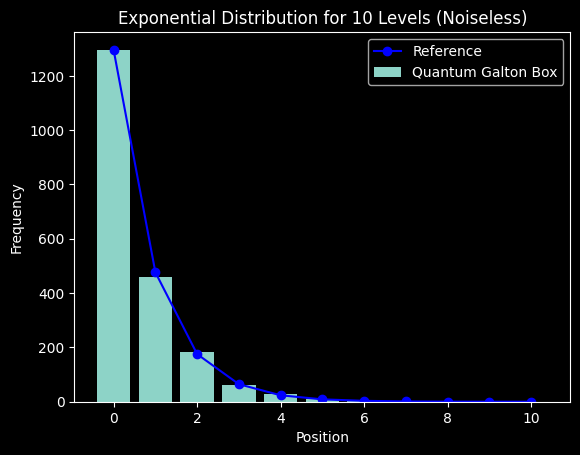

Width and depth of transpiled circuit: 144, 1168
Width and depth after AI Pass: 144, 863


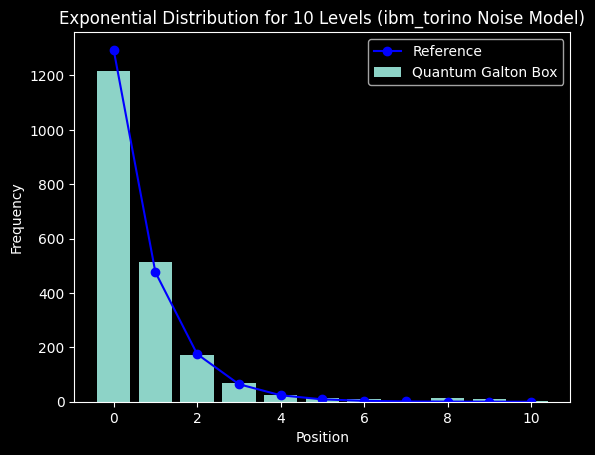

In [19]:
exponential = dg.exponential(generate_probs=True)[1]
results["exponential_noiseless"] = run_simulation(
    n,
    SHOTS,
    create_opt_qgb_circuit,
    optimized_coin,
    RunMode.NOISELESS_SIMULATOR,
    distribution_type=DistributionType.EXPONENTIAL,
    title=f"Exponential Distribution for {n} Levels (Noiseless)",
    probs=exponential,
)
results["exponential_noisy"] = run_simulation(
    n,
    SHOTS,
    create_opt_qgb_circuit,
    optimized_coin,
    RunMode.NOISY_SIMULATOR,
    distribution_type=DistributionType.EXPONENTIAL,
    title=f"Exponential Distribution for {n} Levels ({real_torino.name} Noise Model)",
    backend=real_torino,
    probs=exponential,
)
if ENABLE_REAL_DEVICE:
    results["exponential_real_device"] = run_simulation(
        n,
        SHOTS,
        create_opt_qgb_circuit,
        optimized_coin,
        RunMode.REAL_DEVICE,
        distribution_type=DistributionType.EXPONENTIAL,
        title=f"Exponential Distribution for {n} Levels (Real Device: {real_torino.name})",
        backend=real_torino,
        probs=exponential,
    )
    results["exponential_real_device_mitigated"] = run_simulation(
        n,
        SHOTS,
        create_opt_qgb_circuit,
        optimized_coin,
        RunMode.REAL_DEVICE,
        distribution_type=DistributionType.EXPONENTIAL,
        title=f"Exponential Distribution for {n} Levels (Real Device: {real_torino.name})",
        backend=real_torino,
        mitigate_noise=True,
        probs=exponential,
    )

Now, there is a well-known implementation of Exponential distribution generation on $n$ qubits with $n$ `RY` rotations. This is the most optimal way of generating this specific distribution with only single qubit gates. The implementation is taken from the Classiq SDK. Showing it here just for the completeness.

In [20]:
# Classiq implementation
# repeat(q.len, lambda i: RY(2.0 * atan(exp((-rate * 2.0**i) / 2.0)), q[i]))
def prep_exponential(n, rate) -> QuantumCircuit:
    """Prepare exponential distribution on n qubits."""
    circuit = QuantumCircuit(n, n)
    for i in range(n):
        circuit.ry(2.0 * math.atan(math.exp((-rate * 2.0**i))), i)
    circuit.measure(range(n), range(n))
    return circuit

### Hadamard Random Walk Distribution

Width and depth of transpiled circuit: 24, 50


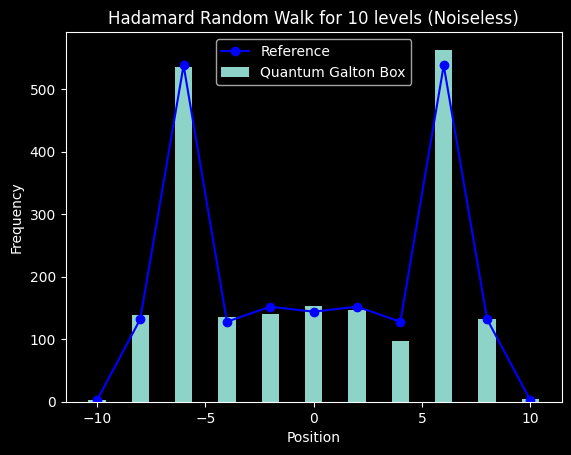

Width and depth of transpiled circuit: 144, 1168
Width and depth after AI Pass: 144, 863


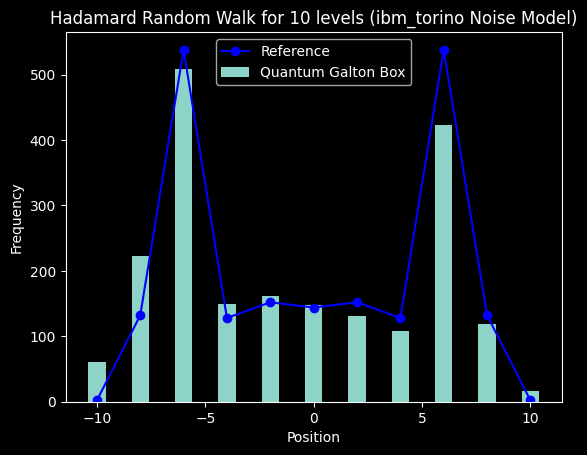

In [21]:
hadamard_probs = dg.hadamard(generate_probs=True)[1]
results["hadamard_noiseless"] = run_simulation(
    n,
    SHOTS,
    create_opt_qgb_circuit,
    optimized_coin,
    RunMode.NOISELESS_SIMULATOR,
    distribution_type=DistributionType.HADAMARD,
    title=f"Hadamard Random Walk for {n} levels (Noiseless)",
    probs=hadamard_probs,
)
results["hadamard_noisy"] = run_simulation(
    n,
    SHOTS,
    create_opt_qgb_circuit,
    optimized_coin,
    RunMode.NOISY_SIMULATOR,
    distribution_type=DistributionType.HADAMARD,
    title=f"Hadamard Random Walk for {n} levels ({real_torino.name} Noise Model)",
    backend=real_torino,
    probs=hadamard_probs,
)
if ENABLE_REAL_DEVICE:
    results["hadamard_real_device"] = run_simulation(
        n,
        SHOTS,
        create_opt_qgb_circuit,
        optimized_coin,
        RunMode.REAL_DEVICE,
        distribution_type=DistributionType.HADAMARD,
        title=f"Hadamard Random Walk for {n} levels (Real Device: {real_torino.name})",
        backend=real_torino,
        probs=hadamard_probs,
    )
    results["hadamard_real_device_mitigated"] = run_simulation(
        n,
        SHOTS,
        create_opt_qgb_circuit,
        optimized_coin,
        RunMode.REAL_DEVICE,
        distribution_type=DistributionType.HADAMARD,
        title=f"Hadamard Random Walk for {n} levels (Real Device: {real_torino.name})",
        backend=real_torino,
        mitigate_noise=True,
        probs=hadamard_probs,
    )

## Part V - Study the Distances between Obtained and Target Distributions

Let's now turn to understanding how well the obtained distributions are approximating the target distributions.

We have collected a hefty amount of samples for both Exponential and Hadamard Random Walk circuits executed under the noise model.

In [22]:
from scipy.stats import wasserstein_distance

Here we calculate the Wasserstein and MSE distances for all the collected results.

In [23]:
wasserstein_distances = {}
for sim_name, (positions, freqs, ref_freqs) in results.items():
    quantum_freqs = np.array(list(freqs.values()))
    reference_freqs = np.array(ref_freqs)
    positions = np.array(positions)

    quantum_probs = quantum_freqs / quantum_freqs.sum()
    reference_probs = reference_freqs / reference_freqs.sum()
    distance = wasserstein_distance(
        u_values=positions,
        v_values=positions,
        u_weights=quantum_probs,
        v_weights=reference_probs,
    )
    tokens = sim_name.split("_")
    for i, t in enumerate(tokens):
        tokens[i] = t[0].upper() + t[1:]
    sim_name_printable = " ".join(tokens)
    print(f"Wasserstein Distance for {sim_name_printable:<40} {distance:.4f}")
    wasserstein_distances[sim_name] = distance

mse_distances = {}
for sim_name, (positions, freqs, ref_freqs) in results.items():
    quantum_freqs = np.array(list(freqs.values()))
    reference_freqs = np.array(ref_freqs)
    positions = np.array(positions)
    quantum_probs = quantum_freqs / quantum_freqs.sum()
    reference_probs = reference_freqs / reference_freqs.sum()

    mse_value = np.mean((quantum_probs - reference_probs) ** 2) * SHOTS
    metric_name = "MSE"

    # Format and output
    tokens = [t[0].upper() + t[1:] for t in sim_name.split("_")]
    sim_name_printable = " ".join(tokens)
    print(f"{metric_name} for {sim_name_printable:<40} {mse_value:.6f}")
    mse_distances[sim_name] = mse_value

Wasserstein Distance for Gaussian Noiseless                       0.0284
Wasserstein Distance for Exponential Noiseless                    0.0164
Wasserstein Distance for Hadamard Noiseless                       0.0645
Wasserstein Distance for Gaussian Noisy                           0.3805
Wasserstein Distance for Exponential Noisy                        0.1621
Wasserstein Distance for Hadamard Noisy                           1.0197
MSE for Gaussian Noiseless                       0.061440
MSE for Exponential Noiseless                    0.016924
MSE for Hadamard Noiseless                       0.085582
MSE for Gaussian Noisy                           0.858496
MSE for Exponential Noisy                        0.346579
MSE for Hadamard Noisy                           1.230599


Now, let's plot the heatmap for those distances.

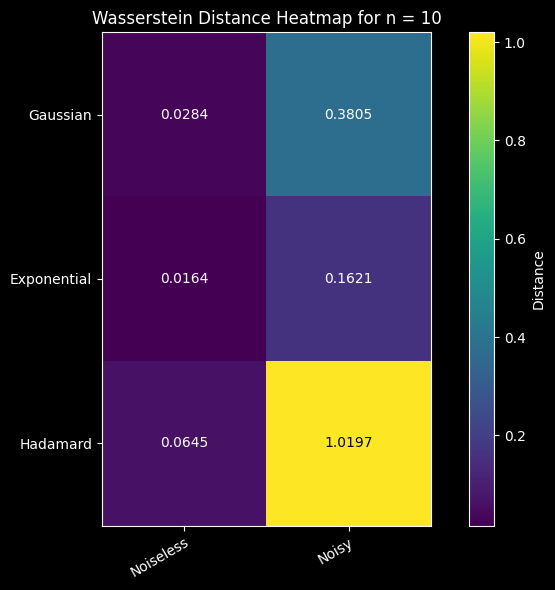

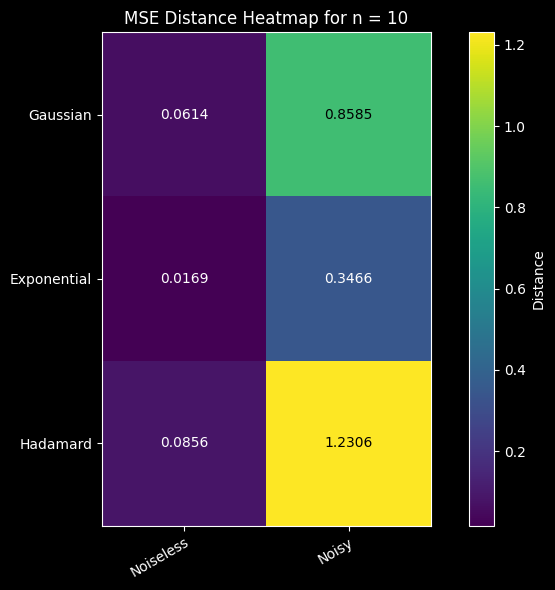

In [24]:
def plot_heatmap(distances, name=""):
    heat_map_distances = np.array(
        [
            [
                distances["gaussian_noiseless"],
                distances["gaussian_noisy"],
                # distances["gaussian_noisy_mitigated"],
            ]
            + (
                [
                    distances["gaussian_real_device"],
                    distances["gaussian_real_device_mitigated"],
                ]
                if ENABLE_REAL_DEVICE
                else []
            ),
            [
                distances["exponential_noiseless"],
                distances["exponential_noisy"],
                # distances["exponential_noisy_mitigated"],
            ]
            + (
                [
                    distances["exponential_real_device"],
                    distances["exponential_real_device_mitigated"],
                ]
                if ENABLE_REAL_DEVICE
                else []
            ),
            [
                distances["hadamard_noiseless"],
                distances["hadamard_noisy"],
                # distances["hadamard_noisy_mitigated"],
            ]
            + (
                [
                    distances["hadamard_real_device"],
                    distances["hadamard_real_device_mitigated"],
                ]
                if ENABLE_REAL_DEVICE
                else []
            ),
        ]
    )
    y_labels = ["Gaussian", "Exponential", "Hadamard"]
    x_labels = ["Noiseless", "Noisy"] + (
        ["Real Device", "Real Device Mitigated"] if ENABLE_REAL_DEVICE else []
    )

    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.imshow(heat_map_distances, cmap="viridis")
    ax.set_xticks(np.arange(len(x_labels)))
    ax.set_yticks(np.arange(len(y_labels)))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")

    for i in range(len(y_labels)):
        for j in range(len(x_labels)):
            ax.text(
                j,
                i,
                f"{heat_map_distances[i, j]:.4f}",
                ha="center",
                va="center",
                color="white" if heat_map_distances[i, j] < 0.5 else "black",
            )

    fig.colorbar(cax, label="Distance")
    ax.set_title(f"{name} Distance Heatmap for n = {n}")
    plt.tight_layout()
    plt.show()


plot_heatmap(wasserstein_distances, "Wasserstein")
plot_heatmap(mse_distances, "MSE")

Hadamard distribution is the worst performing based on both distances. Noise mitigation does improve the accuracy for all distributions.

We would also like to study how noise affects accuracy of the circuits depending on the number of levels of Quantum Galton Board. We will run the simulations for each distribution in the following configuration:
- on the noisy Aer simulator (ibm_torino noise model)
- without M3 noise mitigation
- ranging from 5 to 14 levels

In [25]:
gaussian_noisy_results = defaultdict(int)
exponential_noisy_results = defaultdict(int)
hadamard_noisy_results = defaultdict(int)
for levels in range(5, 15):
    dg = DistributionGenerator(levels, SHOTS)
    gaussian = dg.normal(generate_probs=True)[1]
    exponential = dg.exponential(generate_probs=True)[1]
    hadamard_probs = dg.hadamard(generate_probs=True)[1]
    gaussian_noisy_results[levels] = run_simulation(
        levels,
        SHOTS,
        create_opt_qgb_circuit,
        optimized_coin,
        RunMode.NOISY_SIMULATOR,
        title=f"Normal Distribution for {levels} Levels (Noisy Mitigated)",
        backend=real_torino,
        mitigate_noise=False,
        distribution_type=DistributionType.NORMAL,
        probs=gaussian,
        plots=False,
    )
    exponential_noisy_results[levels] = run_simulation(
        levels,
        SHOTS,
        create_opt_qgb_circuit,
        optimized_coin,
        RunMode.NOISY_SIMULATOR,
        title=f"Exponential Distribution for {levels} Levels (Noisy Mitigated)",
        backend=real_torino,
        mitigate_noise=False,
        distribution_type=DistributionType.EXPONENTIAL,
        probs=exponential,
        plots=False,
    )
    hadamard_noisy_results[levels] = run_simulation(
        levels,
        SHOTS,
        create_opt_qgb_circuit,
        optimized_coin,
        RunMode.NOISY_SIMULATOR,
        title=f"Hadamard Distribution for {levels} Levels (Noisy Mitigated)",
        backend=real_torino,
        mitigate_noise=False,
        distribution_type=DistributionType.HADAMARD,
        probs=hadamard_probs,
        plots=False,
    )

Width and depth of transpiled circuit: 139, 582
Width and depth after AI Pass: 139, 436
Width and depth of transpiled circuit: 139, 578
Width and depth after AI Pass: 139, 423
Width and depth of transpiled circuit: 139, 578
Width and depth after AI Pass: 139, 424
Width and depth of transpiled circuit: 140, 696
Width and depth after AI Pass: 140, 515
Width and depth of transpiled circuit: 140, 696
Width and depth after AI Pass: 140, 515
Width and depth of transpiled circuit: 140, 696
Width and depth after AI Pass: 140, 515
Width and depth of transpiled circuit: 141, 814
Width and depth after AI Pass: 141, 603
Width and depth of transpiled circuit: 141, 818
Width and depth after AI Pass: 141, 615
Width and depth of transpiled circuit: 141, 818
Width and depth after AI Pass: 141, 615
Width and depth of transpiled circuit: 142, 933
Width and depth after AI Pass: 142, 687
Width and depth of transpiled circuit: 142, 932
Width and depth after AI Pass: 142, 685
Width and depth of transpiled ci

In [26]:
def calculate_distance(positions, freqs, reference_freqs):
    """Calculates the MSE distance between two probability distributions."""
    quantum_freqs = np.array(list(freqs.values()))
    reference_freqs = np.array(ref_freqs)
    positions = np.array(positions)
    quantum_probs = quantum_freqs / quantum_freqs.sum()
    reference_probs = reference_freqs / reference_freqs.sum()

    mse_value = np.mean((quantum_probs - reference_probs) ** 2) * SHOTS
    return mse_value

In [27]:
gaussian_distances = defaultdict(int)
exponential_distances = defaultdict(int)
hadamard_distances = defaultdict(int)
for levels, (positions, freqs, ref_freqs) in gaussian_noisy_results.items():
    gaussian_distances[levels] = calculate_distance(positions, freqs, ref_freqs)

for levels, (positions, freqs, ref_freqs) in exponential_noisy_results.items():
    exponential_distances[levels] = calculate_distance(positions, freqs, ref_freqs)

for levels, (positions, freqs, ref_freqs) in hadamard_noisy_results.items():
    hadamard_distances[levels] = calculate_distance(positions, freqs, ref_freqs)

We are now ready to plot the MSE distances of each distribution and their dependence on number of levels.

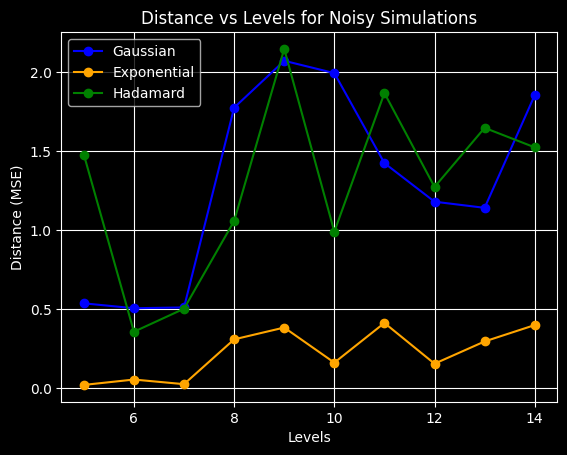

In [28]:
plt.plot(
    list(gaussian_distances.keys()),
    list(gaussian_distances.values()),
    label="Gaussian",
    marker="o",
    color="blue",
)

plt.plot(
    list(exponential_distances.keys()),
    list(exponential_distances.values()),
    label="Exponential",
    marker="o",
    color="orange",
)

plt.plot(
    list(hadamard_distances.keys()),
    list(hadamard_distances.values()),
    label="Hadamard",
    marker="o",
    color="green",
)
plt.xlabel("Levels")
plt.ylabel("Distance (MSE)")
plt.title("Distance vs Levels for Noisy Simulations")
plt.legend()
plt.grid()
plt.show()

We conclude that Exponential distribution realized the most potential from the Galton Board optimizations reducing the number of required qubits from $2n+2$ to $n+3$ and significantly lowering the depth of the circuit. It helped maintaining close enough distance from the reference distribution in the presence of noise and even on a real device.

### Depth Study

Below we show how number of levels of Galton Board affect the depth of the circuit.

Calculated for 2 levels: 158
Calculated for 3 levels: 247
Calculated for 4 levels: 328
Calculated for 5 levels: 423
Calculated for 6 levels: 515
Calculated for 7 levels: 603
Calculated for 8 levels: 687
Calculated for 9 levels: 790
Calculated for 10 levels: 873
Calculated for 11 levels: 943
Calculated for 12 levels: 1042
Calculated for 13 levels: 1138
Calculated for 14 levels: 1220
Calculated for 15 levels: 1293
Calculated for 16 levels: 1394
Calculated for 17 levels: 1464
Calculated for 18 levels: 1560
Calculated for 19 levels: 1652
Calculated for 20 levels: 1733
Calculated for 21 levels: 1829
Calculated for 22 levels: 1900
Calculated for 23 levels: 1982
Calculated for 24 levels: 2091
Calculated for 25 levels: 2178


Text(0.5, 1.0, 'Circuit Depth vs Levels for Optimized QGB Circuit')

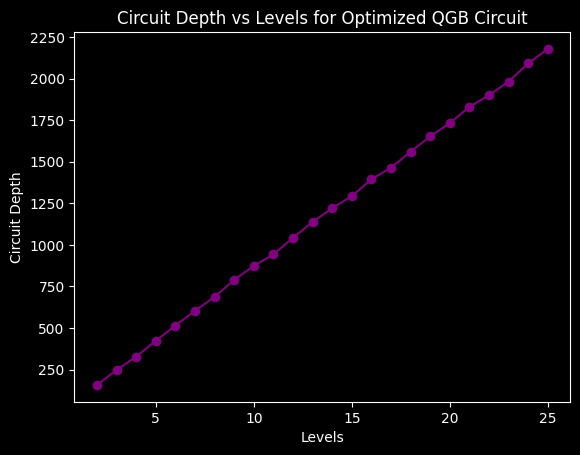

In [29]:
depths_by_levels = {}
for levels in range(2, 26):
    dg = DistributionGenerator(levels, SHOTS)
    gaussian = dg.normal(generate_probs=True)[1]
    circuit = create_opt_qgb_circuit(levels, optimized_coin, gaussian)
    transpiled_circuit = ai_transpile_circuit(
        circuit,
        backend=real_torino,
    )
    depths_by_levels[levels] = transpiled_circuit.depth()
    print(f"Calculated for {levels} levels: {transpiled_circuit.depth()}")

plt.plot(
    list(depths_by_levels.keys()),
    list(depths_by_levels.values()),
    label="Circuit Depth",
    marker="o",
    color="purple",
)
plt.xlabel("Levels")
plt.ylabel("Circuit Depth")
plt.title("Circuit Depth vs Levels for Optimized QGB Circuit")

We can clearly observe pure linear (not quadratic or exponential) growth of the transpiled circuit depth as we add more levels.

In [30]:
for levels, depth in depths_by_levels.items():
    ratio = depth / levels
    print(f"Levels: {levels}, Depth: {depth}, Ratio: {ratio:.2f}")

Levels: 2, Depth: 158, Ratio: 79.00
Levels: 3, Depth: 247, Ratio: 82.33
Levels: 4, Depth: 328, Ratio: 82.00
Levels: 5, Depth: 423, Ratio: 84.60
Levels: 6, Depth: 515, Ratio: 85.83
Levels: 7, Depth: 603, Ratio: 86.14
Levels: 8, Depth: 687, Ratio: 85.88
Levels: 9, Depth: 790, Ratio: 87.78
Levels: 10, Depth: 873, Ratio: 87.30
Levels: 11, Depth: 943, Ratio: 85.73
Levels: 12, Depth: 1042, Ratio: 86.83
Levels: 13, Depth: 1138, Ratio: 87.54
Levels: 14, Depth: 1220, Ratio: 87.14
Levels: 15, Depth: 1293, Ratio: 86.20
Levels: 16, Depth: 1394, Ratio: 87.12
Levels: 17, Depth: 1464, Ratio: 86.12
Levels: 18, Depth: 1560, Ratio: 86.67
Levels: 19, Depth: 1652, Ratio: 86.95
Levels: 20, Depth: 1733, Ratio: 86.65
Levels: 21, Depth: 1829, Ratio: 87.10
Levels: 22, Depth: 1900, Ratio: 86.36
Levels: 23, Depth: 1982, Ratio: 86.17
Levels: 24, Depth: 2091, Ratio: 87.12
Levels: 25, Depth: 2178, Ratio: 87.12


As we can see the ratio of depth to levels is around 87.

## Conclusions

We have demonstrated a universal distribution simulator producing super-position over sparse set of states with Hamming Weight 1. The Galton board approach, with a few optimizations, shows promising results even on the NISQ devices as evidenced from the runs on real IBM backend `ibm_torino`.

Our approach to circuit design has resulted in a significant reduction of required qubits (from $2n+2$ to $n+3$).

The MSE distance hasn't gone over 2 even for larger number of levels, which is another indication of relative accuracy of the model under noisy conditions.

The linear growth of circuit depth assures efficient use of quantum resources and better resilience to noise.